# From Kaggle plate-form

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score
import os
import scipy.io
import math

from sklearn.utils import shuffle

from PIL import Image
import requests
from io import BytesIO

from tensorflow.keras.applications import resnet50
from keras.preprocessing import image

import matplotlib.pyplot as plt

import numpy as np

from keras.applications.imagenet_utils import preprocess_input, decode_predictions

import tensorflow as tf
from keras.preprocessing import image

from sklearn.model_selection import train_test_split

from scipy import spatial
from tqdm import tqdm

import gc

Using TensorFlow backend.


In [2]:
resnet50_model = resnet50.ResNet50(weights='imagenet')

In [3]:
styles = pd.read_csv('/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv', error_bad_lines=False)

shirts = styles[styles['articleType'].isin(['Shirts'])]
tshirts = styles[styles['articleType'].isin(['Tshirts'])]
pants =  styles[styles['articleType'].isin(['Track Pants','Shorts', 'Trunk', 'Trousers', 'Track Pants', 'Tights', 'Lounge Pants', 'Lounge Shorts', 'Leggings', 'Jeans', 'Jeggings'])]
# np.unique(styles['articleType'])
shirts, tshirts, pants = shirts['id'].to_numpy(), tshirts['id'].to_numpy(), pants['id'].to_numpy()
shirts.shape, tshirts.shape, pants.shape

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

((3217,), (7067,), (2445,))

# Constants

In [4]:
image_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/'

IMG_SIZE = 224
LIMIT_IMAGES = 2000
NUM_OUTPUTS = 3

# Load Image Files

In [5]:
def load_imgs(names):
    imgs = []
    for i, image_name in enumerate(tqdm(names)):
#         if i% 50 == 0 :
#             print(f"Loading Image {i}")
        try:
            img = image.load_img(f'{image_path}{image_name}.jpg', target_size=(IMG_SIZE, IMG_SIZE))
        except:
            img = None
        if img is None:
            continue
        img = np.array(img)
        imgs.append(img)
    return np.array(imgs)

In [6]:
print("Loading Images...")
print("Shirts")
shirt_images = load_imgs(shirts[:LIMIT_IMAGES])
gc.collect()
print("TShirts")
tshirt_images = load_imgs(tshirts[:LIMIT_IMAGES])
gc.collect()
print("Pants")
pant_images = load_imgs(pants[:LIMIT_IMAGES])
gc.collect()
print("Done")
shirt_images.shape, tshirt_images.shape, pant_images.shape

  0%|          | 0/2000 [00:00<?, ?it/s]

Loading Images...
Shirts


  0%|          | 0/2000 [00:00<?, ?it/s]

TShirts


  0%|          | 1/2000 [00:00<06:24,  5.20it/s]

Pants


100%|██████████| 2000/2000 [03:49<00:00,  8.70it/s]


Done


((1998, 224, 224, 3), (2000, 224, 224, 3), (1999, 224, 224, 3))

In [7]:
train_shirt_images, test_shirt_images, _, _ = train_test_split(shirt_images, np.repeat(0, shirt_images.shape[0]), test_size = 0.2)
train_shirt_images.shape, test_shirt_images.shape

((1598, 224, 224, 3), (400, 224, 224, 3))

In [8]:
train_tshirt_images, test_tshirt_images, _, _ = train_test_split(tshirt_images, np.repeat(0, tshirt_images.shape[0]), test_size = 0.2)
train_tshirt_images.shape, test_tshirt_images.shape

((1600, 224, 224, 3), (400, 224, 224, 3))

In [9]:
train_pant_images, test_pant_images, _, _ = train_test_split(pant_images, np.repeat(0, pant_images.shape[0]), test_size = 0.2)
train_pant_images.shape, test_pant_images.shape

((1599, 224, 224, 3), (400, 224, 224, 3))

In [10]:
gc.collect()

80

In [11]:
def get_vectors(imgs):
    processed_batch = preprocess_input(imgs, mode="caffe")
    return resnet50_model.predict(processed_batch)

def get_average_vector(imgs):
    vectors = get_vectors(imgs)
    print(vectors.shape)
    return np.mean(vectors, axis=0)

def closeness(a, b):
#     print(a.shape)
#     print(b.shape)
    return 1 - spatial.distance.cosine(a, b)

def closest(vector, compared_to):
    best = -5
    best_idx = -1
#     print(compared_to.shape)
    for i, cmp in enumerate(compared_to):
        c = closeness(vector, cmp)
        if c > best:
            best_idx = i
            best = c
    return best_idx, best

def b_closest(vectors, compared_to):
    return np.array([closest(vector, compared_to)[0] for vector in vectors])

In [12]:
# Get Test And Train Sets
train_X = np.concatenate((train_shirt_images, train_tshirt_images, train_pant_images), axis = 0)
train_Y = np.repeat((0, 1, 2), (train_shirt_images.shape[0], train_tshirt_images.shape[0], train_pant_images.shape[0]), axis = 0)

train_vecs = get_vectors(train_X)

In [13]:
gc.collect()

705

In [14]:
test_X = np.concatenate((test_shirt_images, test_tshirt_images, test_pant_images), axis = 0)
test_Y = np.repeat((0, 1, 2), (test_shirt_images.shape[0], test_tshirt_images.shape[0], test_pant_images.shape[0]), axis = 0)

test_vecs = get_vectors(test_X)

In [15]:
gc.collect()

709

In [36]:
from sklearn.metrics import confusion_matrix, classification_report

# Average Model

In [16]:
shirt_vector = get_average_vector(train_shirt_images)
tshirt_vector = get_average_vector(train_tshirt_images)
pant_vector = get_average_vector(train_pant_images)
gc.collect()

(1598, 1000)
(1600, 1000)
(1599, 1000)


1327

In [17]:
pred_classes = decode_predictions(np.expand_dims(shirt_vector, axis=0), top=3)
pred_classes

40960/35363 [==================================] - 0s 0us/step


[[('n03594734', 'jean', 0.47472385),
  ('n02963159', 'cardigan', 0.12699337),
  ('n03877472', 'pajama', 0.026902892)]]

In [18]:
pred_classes = decode_predictions(np.expand_dims(tshirt_vector, axis=0), top=3)
pred_classes

[[('n03595614', 'jersey', 0.44651836),
  ('n03594734', 'jean', 0.23165378),
  ('n02916936', 'bulletproof_vest', 0.028572833)]]

In [19]:
pred_classes = decode_predictions(np.expand_dims(pant_vector, axis=0), top=3)
pred_classes

[[('n03594734', 'jean', 0.43499964),
  ('n04371430', 'swimming_trunks', 0.10840451),
  ('n03255030', 'dumbbell', 0.08299347)]]

In [20]:
test_vector = np.array([shirt_vector, tshirt_vector, pant_vector])

In [21]:

train_predictions = b_closest(train_vecs, test_vector)

train_accuracy = accuracy_score(train_Y, train_predictions)
print(f"In Sample Accuracy: {train_accuracy}")

In Sample Accuracy: 0.6529080675422139


In [22]:

test_predictions = b_closest(test_vecs, test_vector)

test_accuracy = accuracy_score(test_Y, test_predictions)
print(f"Out Of Sample Accuracy: {test_accuracy}")

Out Of Sample Accuracy: 0.6708333333333333


In [23]:
gc.collect()

120

# NN To Classify

In [24]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline


In [25]:
trainx, trainy = shuffle(train_vecs, train_Y)
# trainx = np.expand_dims(trainx, axis=1)
trainx.shape, trainy.shape

((4797, 1000), (4797,))

In [26]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=1000, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [27]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)

In [28]:
kfold = KFold(n_splits=10, shuffle=True)

In [29]:
classify_model = estimator.fit(trainx, trainy)

In [30]:
preds = estimator.predict(train_vecs)
acc = accuracy_score(train_Y, preds)
print(f"In sample Accuracy: {acc}")

In sample Accuracy: 0.989159891598916


In [31]:
preds = estimator.predict(test_vecs)
acc = accuracy_score(test_Y, preds)
print(f"Out of sample Accuracy: {acc}")

Out of sample Accuracy: 0.9508333333333333


In [32]:
estimator.model.save('/kaggle/working/keras-vlarge-963.h5')

# ADA to classify

In [33]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics

In [34]:
abc = AdaBoostClassifier(n_estimators=400, learning_rate=1)
abcm = abc.fit(trainx, trainy)

In [37]:
preds = abc.predict(train_vecs)
acc = accuracy_score(train_Y, preds)
print(f"In sample Accuracy: {acc}")

print(classification_report(train_Y, preds))

preds = abc.predict(test_vecs)
acc = accuracy_score(test_Y, preds)
print(f"Out of sample Accuracy: {acc}")

print(classification_report(test_Y, preds))

In sample Accuracy: 0.9774859287054409
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1598
           1       0.97      0.96      0.97      1600
           2       1.00      1.00      1.00      1599

    accuracy                           0.98      4797
   macro avg       0.98      0.98      0.98      4797
weighted avg       0.98      0.98      0.98      4797

Out of sample Accuracy: 0.9675
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       400
           1       0.95      0.96      0.96       400
           2       0.99      0.97      0.98       400

    accuracy                           0.97      1200
   macro avg       0.97      0.97      0.97      1200
weighted avg       0.97      0.97      0.97      1200



In [38]:
import pickle
pickle.dump(abc, open('/kaggle/working/ada-vvlarge-964.pickle', 'wb'))

In [39]:
gc.collect()

20

# DL for classify

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [41]:
trainx, trainy = shuffle(train_vecs, train_Y)
trainx.shape, trainy.shape
tx, vx, ty, vy = train_test_split(trainx, trainy, test_size = 0.2)
testx, testy = test_vecs.copy(), test_Y.copy()
tx.shape, ty.shape, vx.shape, vy.shape, testx.shape, testy.shape

((3837, 1000), (3837,), (960, 1000), (960,), (1200, 1000), (1200,))

In [42]:
scaler = MinMaxScaler()
tx = scaler.fit_transform(tx)
vx = scaler.transform(vx)
testx = scaler.transform(testx)

tx.shape, ty.shape, vx.shape, vy.shape, testx.shape, testy.shape

((3837, 1000), (3837,), (960, 1000), (960,), (1200, 1000), (1200,))

In [43]:
EPOCHS = 300
BATCH_SIZE = 100
LEARNING_RATE = 0.00007
NUM_FEATURES = 1000
NUM_CLASSES = NUM_OUTPUTS

In [44]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [45]:
gc.collect()

20

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [47]:
torch_model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
torch_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(torch_model.parameters(), lr=LEARNING_RATE)
print(torch_model)

MulticlassClassification(
  (layer_1): Linear(in_features=1000, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [48]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

In [49]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [50]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(tx).float(), torch.from_numpy(ty).long())
val_dataset = ClassifierDataset(torch.from_numpy(vx).float(), torch.from_numpy(vy).long())
test_dataset = ClassifierDataset(torch.from_numpy(testx).float(), torch.from_numpy(testy).long())

In [51]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [52]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    torch_model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = torch_model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        torch_model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = torch_model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


Epoch 001: | Train Loss: 0.84766 | Val Loss: 0.99532 | Train Acc: 87.179| Val Acc: 41.667
Epoch 002: | Train Loss: 0.56674 | Val Loss: 0.55617 | Train Acc: 100.000| Val Acc: 88.646
Epoch 003: | Train Loss: 0.44589 | Val Loss: 0.42461 | Train Acc: 100.000| Val Acc: 90.312
Epoch 004: | Train Loss: 0.36902 | Val Loss: 0.36104 | Train Acc: 100.000| Val Acc: 92.500
Epoch 005: | Train Loss: 0.31363 | Val Loss: 0.31735 | Train Acc: 100.000| Val Acc: 93.333
Epoch 006: | Train Loss: 0.26469 | Val Loss: 0.28493 | Train Acc: 100.000| Val Acc: 93.854
Epoch 007: | Train Loss: 0.23292 | Val Loss: 0.25621 | Train Acc: 100.000| Val Acc: 94.271
Epoch 008: | Train Loss: 0.20753 | Val Loss: 0.23841 | Train Acc: 100.000| Val Acc: 94.479
Epoch 009: | Train Loss: 0.18301 | Val Loss: 0.22291 | Train Acc: 100.000| Val Acc: 95.312
Epoch 010: | Train Loss: 0.16503 | Val Loss: 0.20840 | Train Acc: 100.000| Val Acc: 95.312
Epoch 011: | Train Loss: 0.15003 | Val Loss: 0.19480 | Train Acc: 100.000| Val Acc: 95.417


In [53]:
y_pred_list = []
with torch.no_grad():
    torch_model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = torch_model(X_batch)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [54]:
print(classification_report(testy, y_pred_list))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       400
           1       0.97      0.92      0.94       400
           2       0.96      0.97      0.96       400

    accuracy                           0.95      1200
   macro avg       0.95      0.95      0.95      1200
weighted avg       0.95      0.95      0.95      1200



In [55]:
pickle.dump(scaler, open('/kaggle/working/torch-vvlarge.scaler.pickle', 'wb'))
torch.save(torch_model.state_dict(), '/kaggle/working/torch-vvlarge.dict')

In [56]:
gc.collect()

63

# New Model

In [57]:
trainx2, trainy2 = shuffle(train_vecs, train_Y)
trainx2.shape, trainy2.shape
tx2, vx2, ty2, vy2 = train_test_split(trainx, trainy, test_size = 0.2)
testx2, testy2 = test_vecs.copy(), test_Y.copy()
tx2.shape, ty2.shape, vx2.shape, vy2.shape, testx2.shape, testy2.shape

((3837, 1000), (3837,), (960, 1000), (960,), (1200, 1000), (1200,))

In [58]:
scaler = MinMaxScaler()
tx2 = scaler.fit_transform(tx2)
vx2 = scaler.transform(vx2)
testx2 = scaler.transform(testx2)

tx2.shape, ty2.shape, vx2.shape, vy2.shape, testx2.shape, testy2.shape

((3837, 1000), (3837,), (960, 1000), (960,), (1200, 1000), (1200,))

In [59]:
EPOCHS = 300
BATCH_SIZE = 100
LEARNING_RATE = 0.00007
NUM_FEATURES = 1000
NUM_CLASSES = NUM_OUTPUTS

In [60]:
gc.collect()

80

In [61]:
class MulticlassClassification2(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification2, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 256)
        self.layer_4 = nn.Linear(256, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(256)
        self.batchnorm4 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_4(x)
        x = self.batchnorm4(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [62]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [63]:
torch_model2 = MulticlassClassification2(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
torch_model2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(torch_model2.parameters(), lr=LEARNING_RATE)
print(torch_model2)



def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

MulticlassClassification2(
  (layer_1): Linear(in_features=1000, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=256, bias=True)
  (layer_4): Linear(in_features=256, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [64]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset2 = ClassifierDataset(torch.from_numpy(tx2).float(), torch.from_numpy(ty2).long())
val_dataset2 = ClassifierDataset(torch.from_numpy(vx2).float(), torch.from_numpy(vy2).long())
test_dataset2 = ClassifierDataset(torch.from_numpy(testx2).float(), torch.from_numpy(testy2).long())

train_loader2 = DataLoader(dataset=train_dataset2,
                          batch_size=BATCH_SIZE
)
val_loader2 = DataLoader(dataset=val_dataset2, batch_size=1)
test_loader2 = DataLoader(dataset=test_dataset2, batch_size=1)

In [65]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    gc.collect()
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    torch_model2.train()
    for X_train_batch, y_train_batch in train_loader2:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = torch_model2(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        torch_model2.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = torch_model2(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    gc.collect()
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


Epoch 001: | Train Loss: 0.90948 | Val Loss: 1.03023 | Train Acc: 82.051| Val Acc: 58.750
Epoch 002: | Train Loss: 0.65939 | Val Loss: 0.59244 | Train Acc: 100.000| Val Acc: 86.146
Epoch 003: | Train Loss: 0.50911 | Val Loss: 0.42884 | Train Acc: 100.000| Val Acc: 90.417
Epoch 004: | Train Loss: 0.40800 | Val Loss: 0.34859 | Train Acc: 100.000| Val Acc: 91.771
Epoch 005: | Train Loss: 0.34463 | Val Loss: 0.29544 | Train Acc: 100.000| Val Acc: 93.750
Epoch 006: | Train Loss: 0.29105 | Val Loss: 0.24929 | Train Acc: 100.000| Val Acc: 94.896
Epoch 007: | Train Loss: 0.25266 | Val Loss: 0.22026 | Train Acc: 100.000| Val Acc: 95.729
Epoch 008: | Train Loss: 0.22270 | Val Loss: 0.19760 | Train Acc: 100.000| Val Acc: 96.042
Epoch 009: | Train Loss: 0.19684 | Val Loss: 0.17701 | Train Acc: 100.000| Val Acc: 96.458
Epoch 010: | Train Loss: 0.17933 | Val Loss: 0.16111 | Train Acc: 100.000| Val Acc: 97.083
Epoch 011: | Train Loss: 0.16020 | Val Loss: 0.14898 | Train Acc: 100.000| Val Acc: 97.188


In [66]:
y_pred_list = []
with torch.no_grad():
    torch_model2.eval()
    for X_batch, _ in test_loader2:
        X_batch = X_batch.to(device)
        y_test_pred = torch_model2(X_batch)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

print(classification_report(testy, y_pred_list))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       400
           1       0.95      0.92      0.93       400
           2       0.96      0.97      0.97       400

    accuracy                           0.95      1200
   macro avg       0.95      0.95      0.95      1200
weighted avg       0.95      0.95      0.95      1200



In [67]:
import pickle

In [68]:
pickle.dump(scaler, open('/kaggle/working/torch-2-vlarge.scaler.pickle', 'wb'))
torch.save(torch_model2.state_dict(), '/kaggle/working/torch-2-vlarge.dict')

In [69]:
gc.collect()

63

In [70]:
def load_img(names):
    print(names)
    imgs = []
    for i, image_name in enumerate(names):
        if i% 50 == 0 :
            print(f"Loading Image {i}")
        img = image.load_img(f'/kaggle/input/vernacular-set/{image_name}.jpeg', target_size=(IMG_SIZE, IMG_SIZE))
        if img is None:
            continue
        img = np.array(img)
        imgs.append(img)
    return np.array(imgs)

In [71]:
pred_imgs = load_img(list(range(1,17)))
pred_imgs.shape
gc.collect()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Loading Image 0


40

In [72]:
pred_vecs = get_vectors(pred_imgs)

In [73]:
preds = abc.predict(pred_vecs)
map_to_names = lambda x: map(lambda y: "Shirt" if y == 0 else "T-Shirt" if y == 1 else "Pant", x)
pred_results = list(zip(map_to_names([0,1,0,0,0,0,1,0,1,1,1,0,2,2,0,0]), map_to_names(preds)))
print(pred_results)

[('Shirt', 'Shirt'), ('T-Shirt', 'T-Shirt'), ('Shirt', 'Shirt'), ('Shirt', 'Shirt'), ('Shirt', 'Shirt'), ('Shirt', 'Shirt'), ('T-Shirt', 'T-Shirt'), ('Shirt', 'Shirt'), ('T-Shirt', 'T-Shirt'), ('T-Shirt', 'T-Shirt'), ('T-Shirt', 'T-Shirt'), ('Shirt', 'Pant'), ('Pant', 'Pant'), ('Pant', 'Pant'), ('Shirt', 'Shirt'), ('Shirt', 'Shirt')]


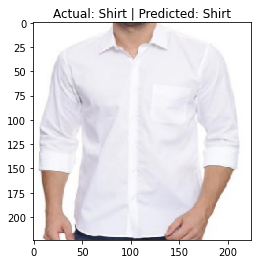

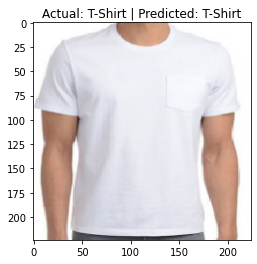

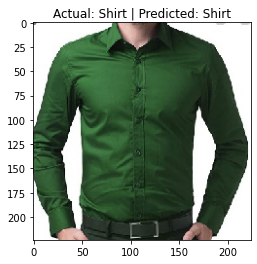

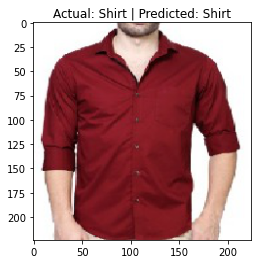

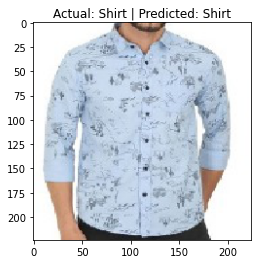

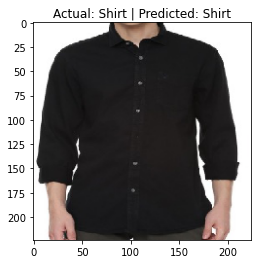

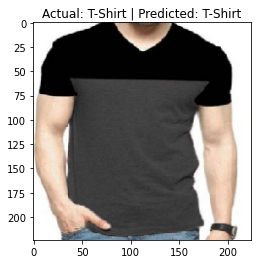

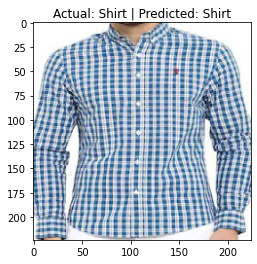

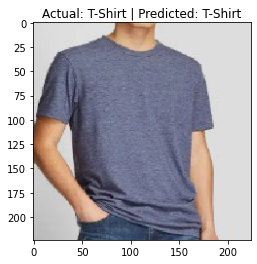

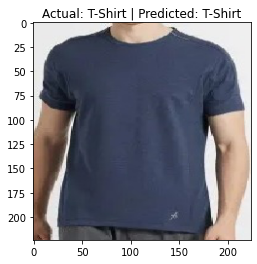

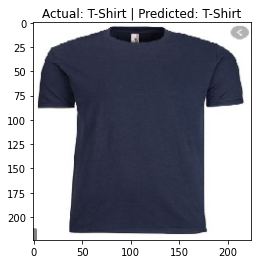

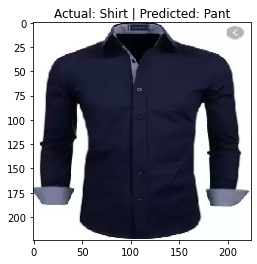

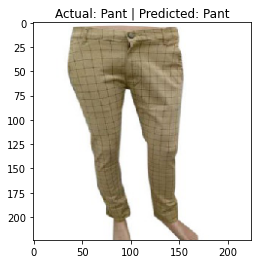

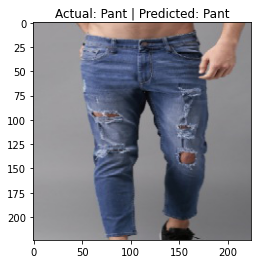

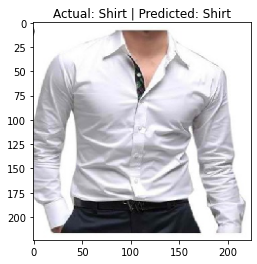

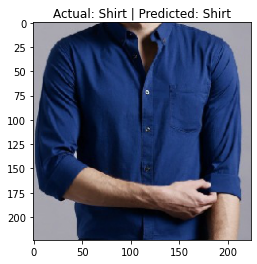

In [74]:
for result, image in zip(pred_results, pred_imgs):
    plt.figure()
    plt.title(f"Actual: {result[0]} | Predicted: {result[1]}")
    plt.imshow(image)
    

In [75]:
gc.collect()

42359